In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
import sys
sys.path.append("/root/autodl-tmp/EasyDS")

# from langchain_deepseek import ChatDeepSeek
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command
from langgraph.prebuilt import ToolNode

from pydantic import BaseModel, Field, ConfigDict, field_validator
from typing import Annotated, List, Optional, Dict, Any, Literal, TypedDict
import json

In [2]:
# llm = ChatDeepSeek(model="deepseek-chat", openai_api_key=os.getenv("DEEPSEEK_API_KEY"))
api_key = os.getenv("DEEPSEEK_API_KEY")
llm = ChatOpenAI(model="deepseek-chat", openai_api_key=api_key, openai_api_base='https://api.deepseek.com', temperature=0.9, max_tokens=1000)

## 智能体间的通讯状态

In [3]:
class State(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages] = Field(default_factory=list, title="对话列表")
    question: list = Field(default=[], title="当前题目信息")
    evaluation: dict = Field(default={}, title="用户回复评估")
    log: str = Field(default="", title="节点执行日志")

## Router Agent

接收历史对话信息以及最新的用户回复进行路由选择

- 如果用户回复内容错误
    - 直接转向 Teacher Agent

- 如果用户回复内容正确
    - 回复错误，转向 Teacher Agent 进行纠正
    - 回复正确且完整，转向 Teacher Agent 进行总结
    - 回复正确，但是不完整，转向 Student Agent 进行追问
    - 回复不完整，转向 Student Agent 进行进一步的追问

In [4]:
class Evaluation(TypedDict):
    is_right: bool = Field(default=None, title="用户回复是否正确")
    is_complete: bool = Field(default=None, title="用户回复是否完整")
    reason: str = Field(default="", title="用户回复评估原因")
    next_agent: Literal["teacher", "student"]
    

async def router_agent(state: State, config) -> Command[Literal["teacher_agent", "student_agent"]]:
    """根据当前状态进行路由"""
    try:
        curr_question = state.question[0]
        with open("/root/autodl-tmp/EasyDS/src/agents/prompts/router_agent_prompt.txt", "r", encoding="utf-8") as f:
            prompt = f.read()
        prompt = ChatPromptTemplate([
            ("system", prompt),
            MessagesPlaceholder(variable_name="messages")
        ])
        system_prompt = prompt.partial(title=curr_question['title'],content=curr_question['content'],answer=curr_question['reference_answer']['content'],explanation=curr_question['reference_answer']['explanation'])
        chain = system_prompt | llm.with_structured_output(Evaluation, method="function_calling")
        router_result = await chain.ainvoke({"messages": state.messages}, config)
        if router_result['next_agent'] == 'teacher':
            goto = "teacher_agent"
        else:
            goto = "student_agent"
        return Command(
            update={
                "evaluation": router_result,
            },
            goto=goto
        )
    except Exception as e:
        return Command(
            update={
                "log": str(e)
            },
            goto="teacher_agent"                           
        )


## Student Agent

根据从 Router Agent 转来的状态进行回复

In [5]:
async def student_agent(state: State, config) -> State:
    try:
        curr_question = state.question[0]
        evaluation = state.evaluation
        with open("/root/autodl-tmp/EasyDS/src/agents/prompts/student_agent_prompt2.txt", "r", encoding="utf-8") as f:
            prompt = f.read()
        prompt = ChatPromptTemplate([
            ("system", prompt),
            ("human", "{messages}")
        ])
        system_prompt = prompt.partial(
            title=curr_question['title'],
            content=curr_question['content'],
            answer=curr_question['reference_answer']['content'],
            explanation=curr_question['reference_answer']['explanation'],
            is_right=evaluation['is_right'],
            is_complete=evaluation['is_complete'],
            reason=evaluation['reason']
        )
        chain = system_prompt | llm
        stu_feedback = await chain.ainvoke({"messages": state.messages}, config)
        return {"messages": stu_feedback}
    except Exception as e:
        return {"log": str(e)}


## Teacher Agent

根据从路由智能体转来的状态进行回复

- 如果 is_right == False，即用户回答错误，teacher_agent 进行错误分类与讲解建议
- 如果 is_right == True，进行总结
- 如果 is_right == None, 回答用户问题

In [6]:
from data.ds_data.data_processing.index_builder import KnowledgeIndexSystem

async def knowledge_summry_search(knowledge_points: list):
    """根据知识点列表查询知识点概述"""
    try:
        system = await KnowledgeIndexSystem.load_indices_async('/root/autodl-tmp/EasyDS/data/ds_data/ds_indices.pkl')
        knowledge_summry = []
        for kp in knowledge_points:
            knowledge_point_info = await system.get_knowledge_point_async(kp)
            if knowledge_point_info:    
                knowledge_summry.append({
                    "knowledge_point": knowledge_point_info['title'],
                    "summry": knowledge_point_info['summry']
                })
        if knowledge_summry:
            # 将知识点的概述进行拼接
            knowledge_summry_str = "\n".join([f"{kp['knowledge_point']}: {kp['summry']}" for kp in knowledge_summry])
            return knowledge_summry_str
        else:
            return "未找到对应知识点"
    except Exception as e:
        return str(e)
tools = [knowledge_summry_search]

In [7]:

async def teacher_agent(state: State, config) -> Command[Literal["tool_node", "__end__"]]:
    """根据当前状态进行回复"""
    try:
        curr_question = state.question[0]
        evaluation = state.evaluation
        with open("/root/autodl-tmp/EasyDS/src/agents/prompts/teacher_agent_prompt.txt", "r", encoding="utf-8") as f:
            prompt = f.read()
        prompt = ChatPromptTemplate([
            ("system", prompt),
            ("human", "{messages}")
        ])
        system_prompt = prompt.partial(
            title=curr_question['title'],
            content=curr_question['content'],
            answer=curr_question['reference_answer']['content'],
            knowledge_points=curr_question['knowledge_points'],
            explanation=curr_question['reference_answer']['explanation'],
            is_right=evaluation['is_right'],
            is_complete=evaluation['is_complete'],
            reason=evaluation['reason']
        )
        chain = system_prompt | llm.bind_tools(tools)
        teacher_feedback = await chain.ainvoke({"messages": state.messages}, config)
        if teacher_feedback.tool_calls:
            goto = "tool_node"
        else:
            goto = "__end__"
        return Command(
            update={
                "messages": teacher_feedback
            },
            goto=goto
        )
    except Exception as e:
        return Command(
            update={
                "log": str(e)
            },
            goto="__end__"
        )


## MainGraph

In [8]:
workflow = StateGraph(State)

workflow.add_node("router_agent", router_agent)
workflow.add_node("student_agent", student_agent)
workflow.add_node("teacher_agent", teacher_agent)
workflow.add_node("tool_node", ToolNode(tools))
workflow.add_edge(START, "router_agent")
workflow.add_edge("tool_node", "teacher_agent")
workflow.add_edge("student_agent", "__end__")

memory = MemorySaver()

graph = workflow.compile(checkpointer=memory)


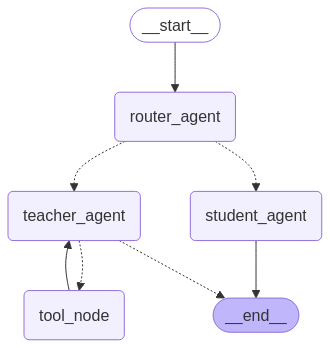

In [9]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=2).draw_mermaid_png()))

In [10]:
system = KnowledgeIndexSystem.load_indices('/root/autodl-tmp/EasyDS/data/ds_data/ds_indices.pkl')
question = system.get_question("q011002")

In [11]:
from uuid import uuid4
config = {"configurable": {"thread_id": str(uuid4())}}
inputs = {
    "messages": [HumanMessage(content="A")],
    "question": [question],
    "evaluation": {},
    "log": ""
}
async for msg, metadata in graph.astream(inputs, config, stream_mode="messages"):
    print(msg.content, end="|")

||||||||||||||||||||||||||||||||||||||明白了|！|既然|树|是|1|对|多的|关系|，|那|在实际|应用中|，|这种|非线性|特性|具体|会|带来|哪些|优势|呢|？|比如|和|线性|结构|相比|，|在处理|某些|问题时|树|结构|会更|高效|吗|？||

In [ ]:
from uuid import uuid4
config = {"configurable": {"thread_id": str(uuid4())}}
inputs = {
    "messages": [HumanMessage(content="线性结构是一对一的关系，而树是1对多的关系，所以是非线性结构")],
    "question": [question],
    "evaluation": {},
    "log": ""
}
async for msg, metadata in graph.astream(inputs, config, stream_mode="messages"):
    print(msg.content, end="|")